In [48]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from statsmodels.stats.outliers_influence import variance_inflation_factor
import networkx as nx
from collections import Counter


In [2]:
connection_df = pd.read_csv("C:\\Users\\51325\\Documents\\connectome_informed\\connections.csv")
community_label_df = pd.read_csv("C:\\Users\\51325\\Documents\\connectome_informed\\processed_labels.csv")
cell_types_df = pd.read_csv("C:\\Users\\51325\\Documents\\connectome_informed\\consolidated_cell_types.csv")
sensory_info_df = pd.read_csv("C:\\Users\\51325\\Documents\\connectome_informed\\classification.csv")
mask_fru_dsx = community_label_df["processed_labels"].apply(lambda labels: any(tag in labels for tag in ["fru", "dsx"]))
fru_dsx_df = community_label_df[mask_fru_dsx]

In [3]:
def build_sensory_seed_groups(sensory_info_df):
    groups = {}
    grouped = sensory_info_df.dropna(subset=["super_class"]).groupby("super_class")
    for cls, df in grouped:
        try:
            root_ids = pd.to_numeric(df["root_id"], errors="coerce").dropna().astype("Int64").unique().tolist()
            groups[cls] = root_ids
        except Exception as e:
            print(f"Skipping class {cls} due to error: {e}")
    return groups
    
sensory_groups = build_sensory_seed_groups(sensory_info_df)


# 1. The random walk algorithm

#### So in this version we select neurons that are in the seeds neuron and just choose them as start node and random walk based on the connectivity as probability, then we perform the same experiment mutiple times and select top 50 neurons that are most walked and mapped them to the community labels.

#### *Big assumption here : We assume neurons only talk through physical connection and we assume synaptic number = connection strength*


In [158]:
fru_dsx_ids = fru_dsx_df["root_id"].tolist()
AN_SMP_3_ids = [720575940614501672,720575940619661888]
oviDN_ids = [720575940620625880,720575940621257340,720575940632512156,720575940603980256,720575940646173748,720575940641518733,720575940642312136,720575940627921182,720575940612153041,720575940610760306]
vpoDN_ids = [720575940613170498,720575940627496829]
SAG_ids = [720575940623363000,720575940631004202]
VES_ids=[720575940633901395,720575940632042148]
CB0595=[720575940607541955,720575940625185317,720575940605068390,720575940617895051,720575940623423467,720575940630757516,720575940623194126,720575940640796045,720575940626556177,720575940627293457,720575940626297621,720575940621478358,720575940653578742,720575940628837852,720575940625337116]
seeds_id_rm = SAG_ids+ vpoDN_ids+ oviDN_ids

In [159]:
seed_groups = {
    "fru_dsx": fru_dsx_df["root_id"].tolist(),
    "AN_SMP_3": [720575940614501672, 720575940619661888],
    "oviDN": [720575940620625880, 720575940621257340, 720575940632512156,
               720575940603980256, 720575940646173748, 720575940641518733,
               720575940642312136, 720575940627921182, 720575940612153041,
               720575940610760306],
    "vpoDN": [720575940613170498, 720575940627496829],
    "SAG": [720575940623363000, 720575940631004202],
    "VES": [720575940633901395, 720575940632042148],
    "CB0595": [720575940607541955, 720575940625185317, 720575940605068390,
                720575940617895051, 720575940623423467, 720575940630757516,
                720575940623194126, 720575940640796045, 720575940626556177,
                720575940627293457, 720575940626297621, 720575940621478358,
                720575940653578742, 720575940628837852, 720575940625337116]
}

In [57]:
def build_connectome_matrix(connection_df):
    all_sources = connection_df["pre_root_id"].unique()
    all_targets = connection_df["post_root_id"].unique()
    nodes = list(np.unique(np.concatenate([all_sources, all_targets], axis=0)))
    N = len(nodes)
    id_to_idx = {nid: i for i, nid in enumerate(nodes)}

    row_idx = connection_df["pre_root_id"].map(id_to_idx).to_numpy()
    col_idx = connection_df["post_root_id"].map(id_to_idx).to_numpy()
    weights = connection_df["syn_count"].astype(np.float32).to_numpy()
    A = csr_matrix((weights, (row_idx, col_idx)), shape=(N, N), dtype=np.float32)

    row_sums = np.array(A.sum(axis=1)).flatten()
    row_sums[row_sums == 0] = 1
    P = A.multiply((1.0 / row_sums)[:, np.newaxis])

    return P, nodes, id_to_idx, A

P, nodes, id_to_idx, A = build_connectome_matrix(connection_df)
# --- Main random walk function ---
def run_random_walk(seed_ids, P, nodes, id_to_idx, community_label_df, num_steps=30, top_k=50, print_state=0):
    N = len(nodes)
    v = np.zeros(N, dtype=np.float32)
    for nid in seed_ids:
        idx = id_to_idx.get(nid)
        if idx is not None:
            v[idx] = 1.0

    v0 = v.copy()
    scores = np.zeros_like(v)
    history = [v.copy()]

    for _ in range(num_steps):
        scores += v
        v = P.T.dot(v)
        history.append(v.copy())

    scores += v - v0
    vend = v.copy()

    top_idx = np.argsort(-scores)[:top_k]
    top_scores = scores[top_idx]
    top_neurons = [nodes[i] for i in top_idx]

    top_df = pd.DataFrame({
        "root_id": top_neurons,
        "score": top_scores
    })
    top_df = top_df.merge(community_label_df, on="root_id", how="left")

    if print_state == 1:
        root_id_string = ",".join(str(x) for x in top_df["root_id"])
        print(root_id_string)

    return top_df, vend, scores, history

top_df, vend, scores, history = run_random_walk(seed_ids = seeds_id_rm, P = P, nodes = nodes, id_to_idx = id_to_idx, community_label_df = community_label_df, num_steps=30, top_k=100, print_state=0)

# 2. Quick Sanity check of the algorithm properties

#### 1. linear, non linear correlationship with synaptic count? (Do bigger neuron more likely to be the information hub?) 

No. However, in order to further confirm this we need to remove the direct neuron connections from the lists to make sure the data is not correlated simply because of the noise added by the direct connection of neuron

#### 2. Step evolution check, when would this score list start to emerge instead of direct connection and when do it starts to being trapped by neurons 

The step happening linearly and most system stops the process around step 15

#### 3. Seed Neuron specificity check, do random fru or dsx neuron have same outcome as the seed neuron, we can possibily remove motor neurons that are shared after walk 

We remove the motor neurons shared across all system(visual, descending, ascending, etc.) that are top 200 neurons after 20 steps. We also check the specific neurons that is tailored to our seeds(OviDN and VpoDN in this case), we found out some neurons is overalapping between those two groups, thus we get some seeds specific neurons. Which leads us to reexammine the idea of question 1

#### 4.If the information are trapped with the constant loop(do neuron have more recurrent connection tend to score higher?) 

Yes, Merge after 20 steps

                  score  in_degree  out_degree  in_syn_count  out_syn_count
score          1.000000   0.080589    0.078202      0.153524      -0.007929
in_degree      0.080589   1.000000    0.673986      0.904832       0.681832
out_degree     0.078202   0.673986    1.000000      0.487670       0.972836
in_syn_count   0.153524   0.904832    0.487670      1.000000       0.521752
out_syn_count -0.007929   0.681832    0.972836      0.521752       1.000000


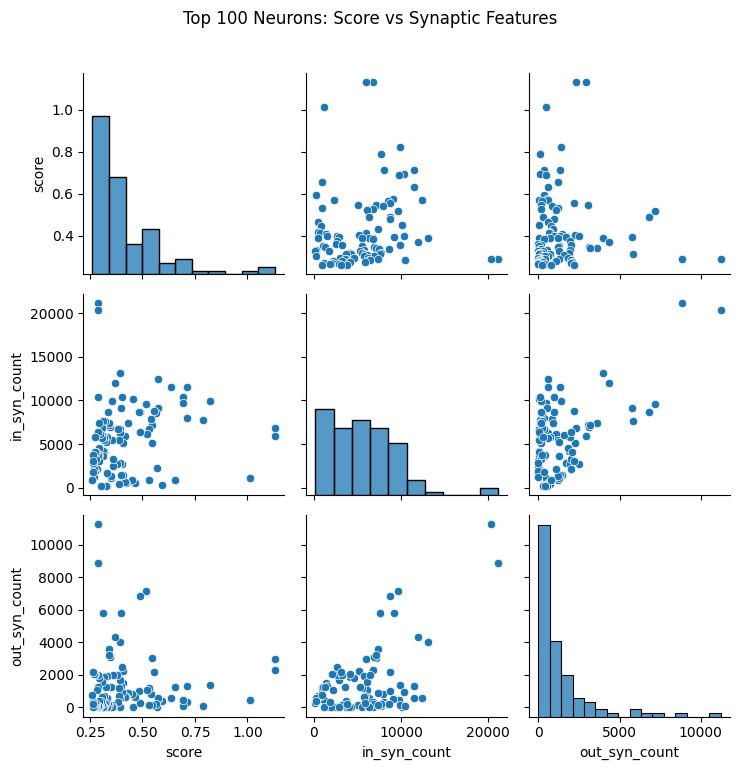

In [15]:
# Assume:
# - scores: numpy array of shape (N,)
# - A: csr_matrix of shape (N, N)
# - nodes: list of root_ids
# - community_label_df: DataFrame with "root_id" and labels

# 1. Get top 100 neurons by score
top_idx = np.argsort(-scores)[:100]
top_scores = scores[top_idx]
top_nodes = [nodes[i] for i in top_idx]

# 2. Compute connectivity features for those top neurons
in_degree = A.T.getnnz(axis=1)
out_degree = A.getnnz(axis=1)
in_syn_count = np.array(A.sum(axis=0)).flatten()
out_syn_count = np.array(A.sum(axis=1)).flatten()

# 3. Build a DataFrame
df_top100 = pd.DataFrame({
    "root_id": [nodes[i] for i in top_idx],
    "score": scores[top_idx],
    "in_degree": in_degree[top_idx],
    "out_degree": out_degree[top_idx],
    "in_syn_count": in_syn_count[top_idx],
    "out_syn_count": out_syn_count[top_idx]
})

# 4. Merge with community labels
df_top100 = df_top100.merge(community_label_df, on="root_id", how="left")

# 5. Correlation matrix
corr = df_top100[["score", "in_degree", "out_degree", "in_syn_count", "out_syn_count"]].corr()
print(corr)

# 6. Visualization
sns.pairplot(df_top100[["score", "in_syn_count", "out_syn_count"]])
plt.suptitle("Top 100 Neurons: Score vs Synaptic Features", y=1.02)
plt.tight_layout()
plt.show()

## 1. check linear and non linear correlation between synaptic count and score

In [8]:
features = ["in_syn_count", "out_syn_count", "in_degree", "out_degree"]

print("Correlation between score and each feature:\n")
for feature in features:
    x = df_top100[feature]
    y = df_top100["score"]

    # Linear correlation
    r_lin, p_lin = pearsonr(x, y)
    r2_lin = r_lin**2

    # Non-linear (monotonic) correlation
    r_spear, p_spear = spearmanr(x, y)

    print(f"{feature}:")
    print(f"  Pearson r = {r_lin:.3f}, R² = {r2_lin:.3f}, p = {p_lin:.3e}")
    print(f"  Spearman ρ = {r_spear:.3f}, p = {p_spear:.3e}")
    print()


Correlation between score and each feature:

in_syn_count:
  Pearson r = 0.154, R² = 0.024, p = 1.273e-01
  Spearman ρ = 0.262, p = 8.493e-03

out_syn_count:
  Pearson r = -0.008, R² = 0.000, p = 9.376e-01
  Spearman ρ = 0.142, p = 1.574e-01

in_degree:
  Pearson r = 0.081, R² = 0.006, p = 4.254e-01
  Spearman ρ = 0.192, p = 5.574e-02

out_degree:
  Pearson r = 0.078, R² = 0.006, p = 4.393e-01
  Spearman ρ = 0.187, p = 6.202e-02



### check multivariate correlation(colinearity so no need)

## 2. Loop check

In [16]:
def plot_stability_over_time(seed_ids, P, nodes, id_to_idx, community_label_df, num_steps=30,
                             top_Ns=[20, 50, 100,500], seed_name="Seed"):
    # Use run_random_walk to get history
    _, _, _, history = run_random_walk(
        seed_ids=seed_ids,
        P=P,
        nodes=nodes,
        id_to_idx=id_to_idx,
        community_label_df=community_label_df,
        num_steps=num_steps,
        top_k=0,
        print_state=0
    )

    jaccard_results = {n: [] for n in top_Ns}
    for N in top_Ns:
        top_neuron_ranks = [set(np.argsort(-vstep)[:N]) for vstep in history]
        for i in range(1, len(top_neuron_ranks)):
            prev = top_neuron_ranks[i - 1]
            curr = top_neuron_ranks[i]
            intersection = len(prev & curr)
            union = len(prev | curr)
            jaccard = intersection / union
            jaccard_results[N].append(jaccard)

    plt.figure(figsize=(12, 6))
    for N, jaccard_scores in jaccard_results.items():
        plt.plot(range(1, len(jaccard_scores) + 1), jaccard_scores, label=f"Top {N}", marker='o')

    plt.xlabel("Step")
    plt.ylabel("Jaccard Overlap with Previous Step")
    plt.title(f"Stability of Top-N Rankings Over Time — {seed_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

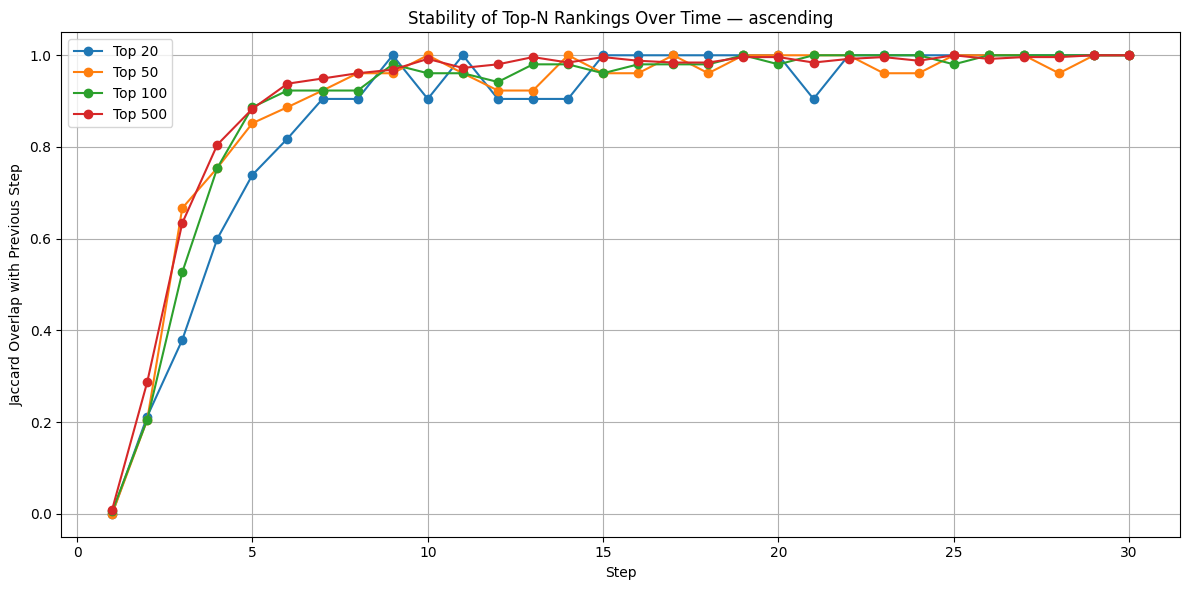

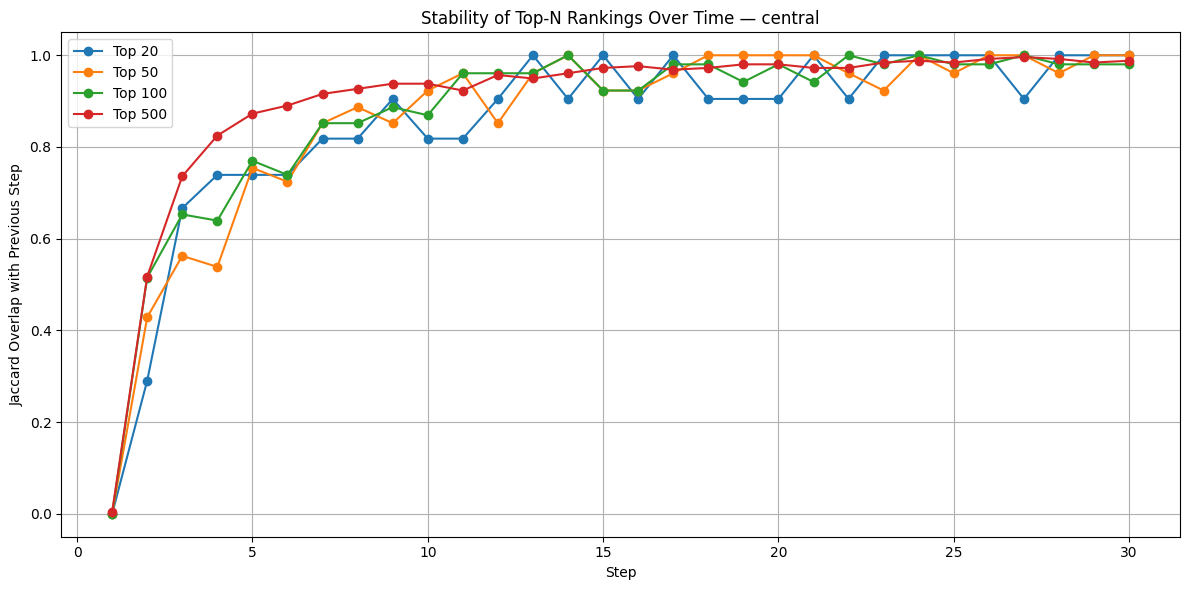

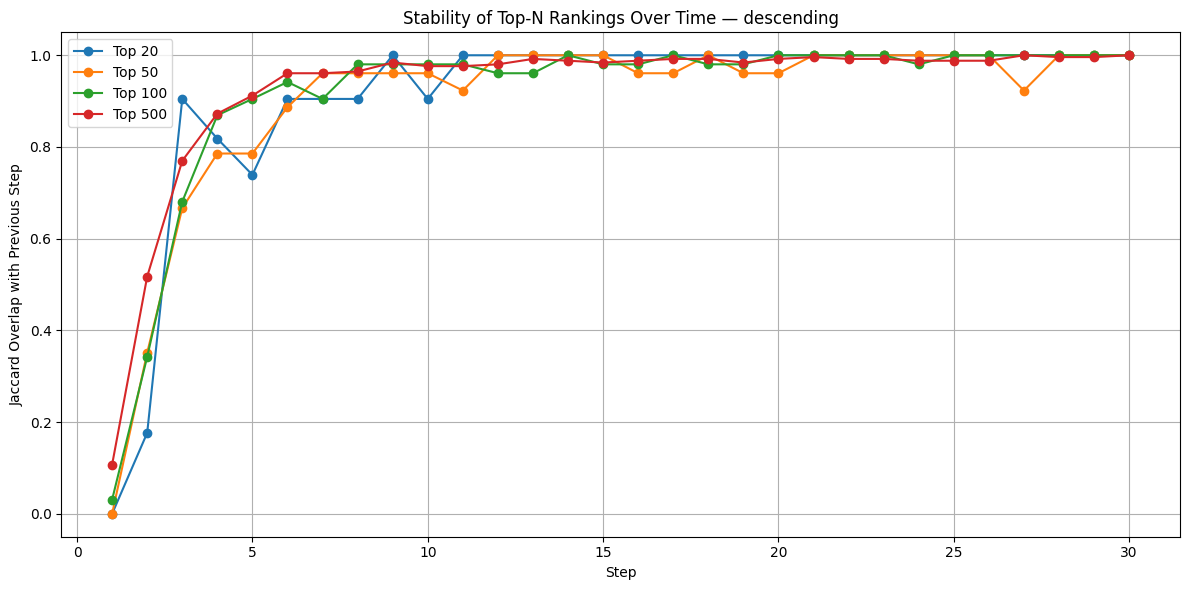

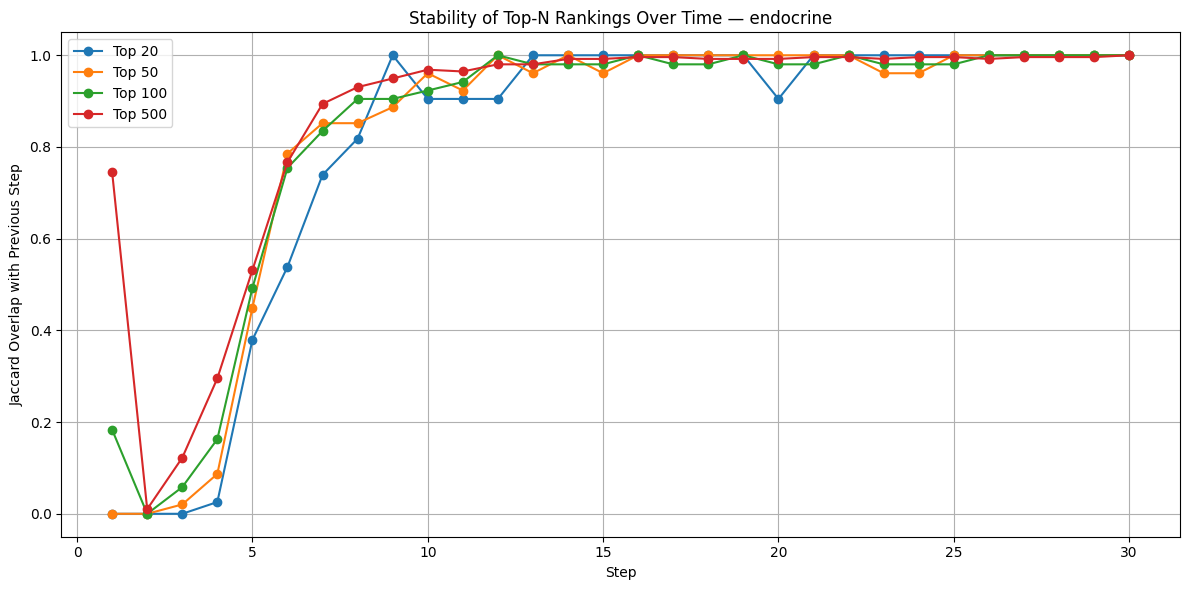

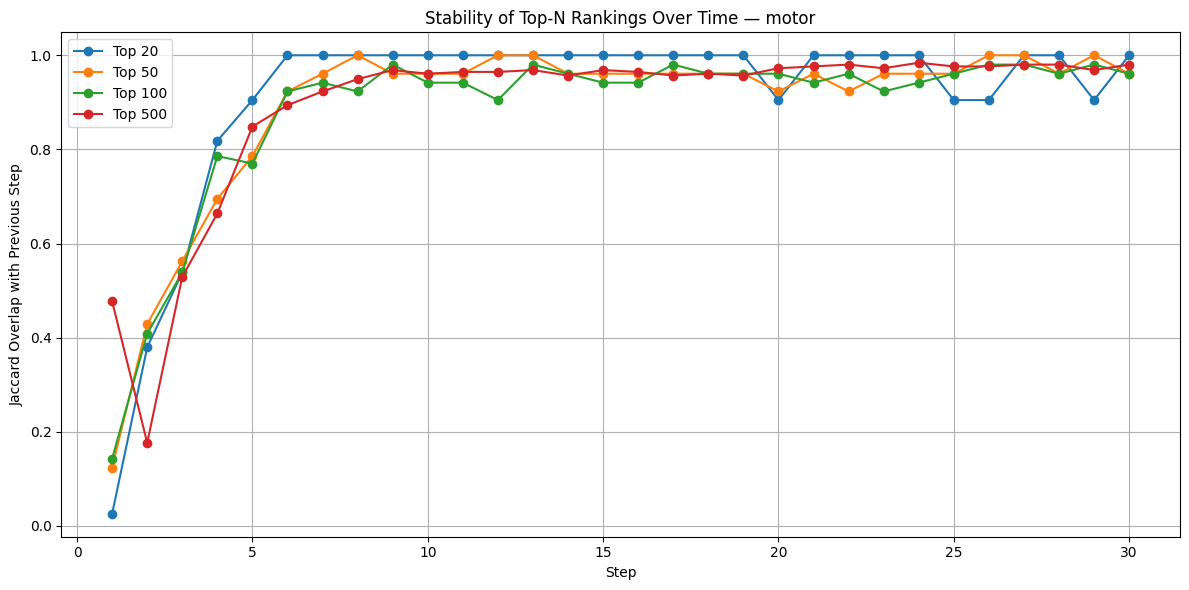

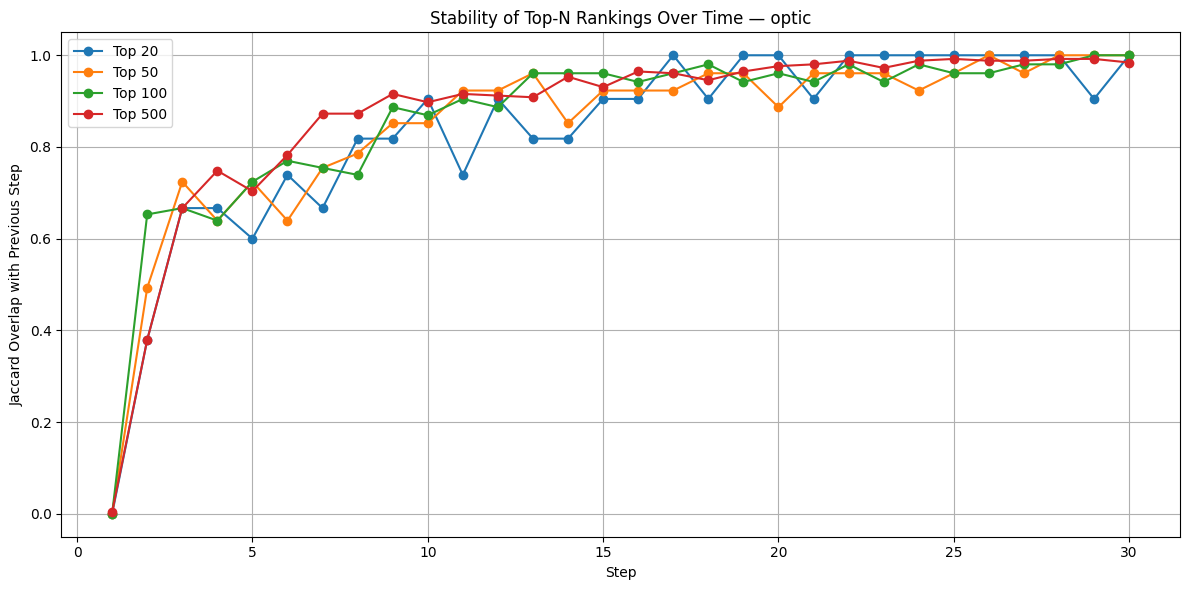

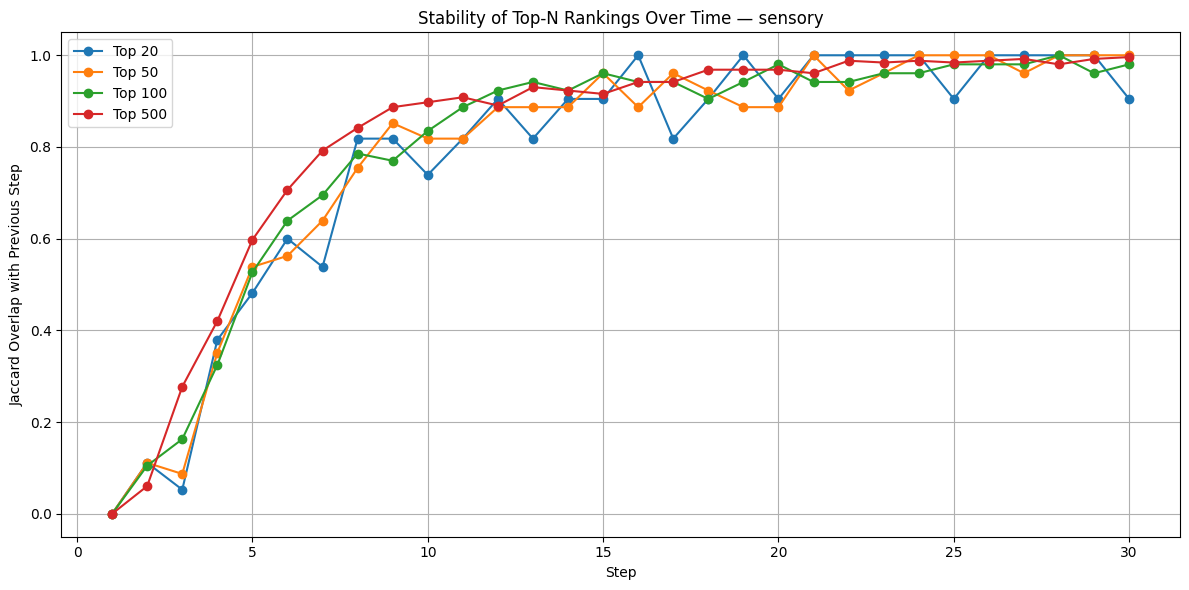

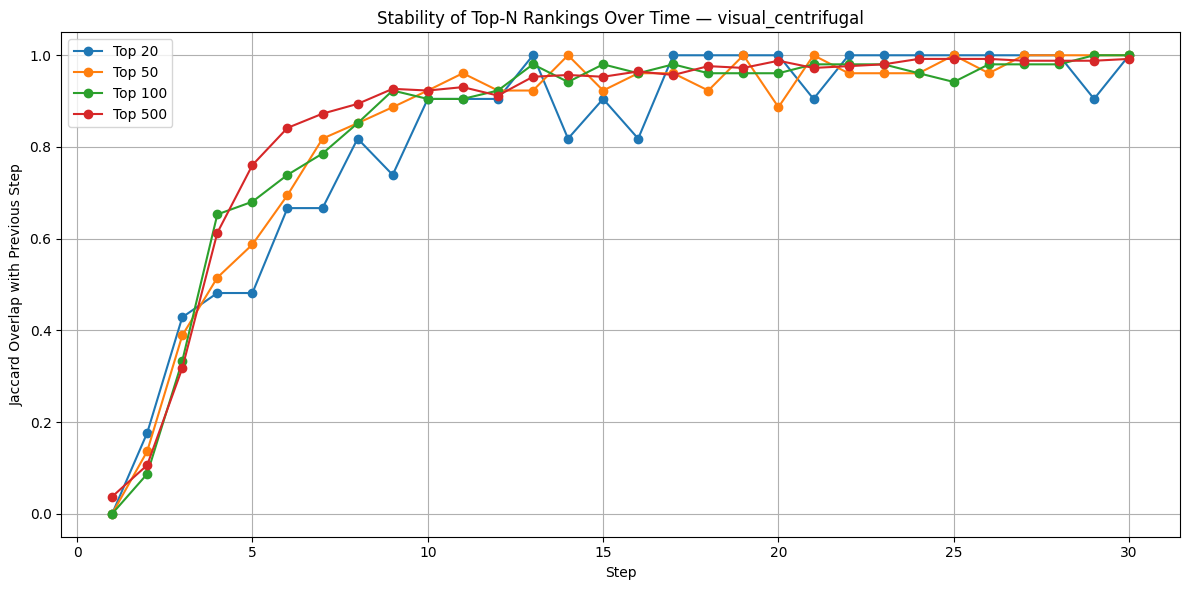

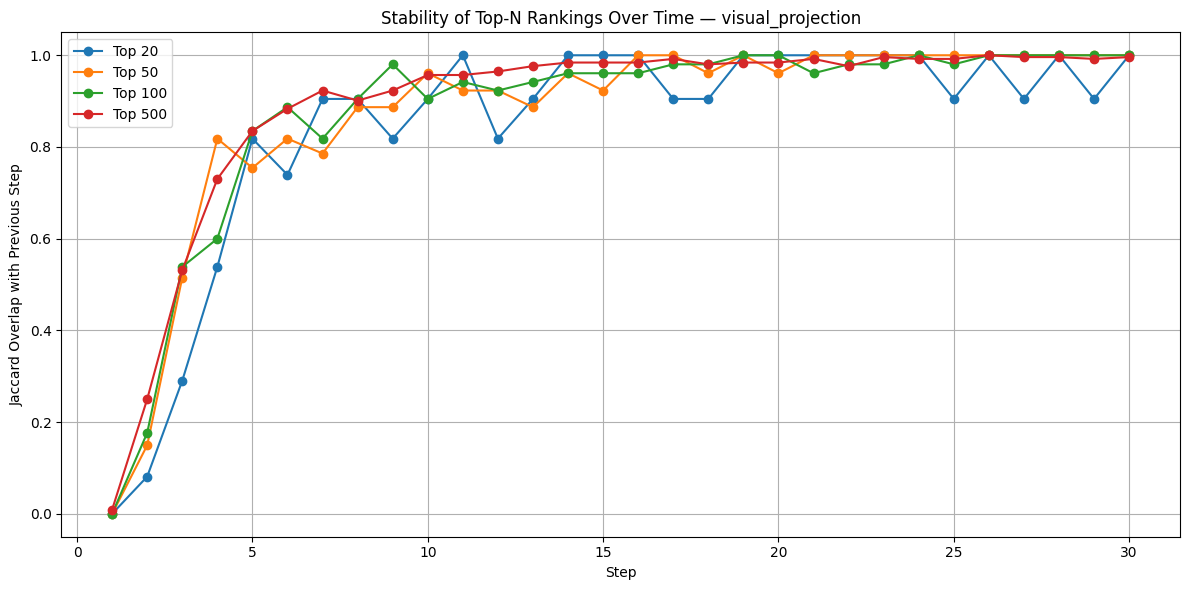

In [17]:
for name, ids in sensory_groups.items():
    plot_stability_over_time(
        seed_ids=ids,
        P=P,
        nodes=nodes,
        id_to_idx=id_to_idx,
        community_label_df=community_label_df,
        seed_name=name
    )

#### 2.1 Remove all the motor neurons at the end: 

Our observation tells us that neurons will eventually getting trapped in the recurrent loop of the motor system, now we collect those common neurons and then remove them from the list

In [160]:
top_dfs_by_modality = {}
for name, ids in sensory_groups.items():
        top_df, vend, scores, history = run_random_walk(seed_ids = ids, P = P, nodes = nodes, id_to_idx = id_to_idx, community_label_df = community_label_df, num_steps=20, top_k=200, print_state=0)
        top_dfs_by_modality[name] = top_df

In [161]:
neuron_counter = Counter()
for name, df in top_dfs_by_modality.items():
    neuron_counter.update(df["root_id"])

min_modalities = 4 # You can change this to 2, 3, etc.
common_neurons = {nid for nid, count in neuron_counter.items() if count >= min_modalities}

common_neuron_labels = community_label_df[
    community_label_df["root_id"].isin(common_neurons)
].copy()

print(f"Neurons appearing in at least {min_modalities} modalities: {len(common_neurons)}")


Neurons appearing in at least 4 modalities: 180


In [162]:
common_neuron_labels.to_csv("converging_neurons_across_modalities.csv", index=False)

In [163]:
filtered_top_dfs_by_modality = {}

for name, df in top_dfs_by_modality.items():
    filtered_df = df[~df["root_id"].isin(common_neurons)].copy()
    filtered_top_dfs_by_modality[name] = filtered_df

In [170]:
top_df_rm, vend, scores, history = run_random_walk(seed_ids = seeds_id_rm, P = P, nodes = nodes, id_to_idx = id_to_idx, community_label_df = community_label_df, num_steps=25, top_k=80, print_state=0)

In [171]:
top_df_fru_dsx, vend, scores, history = run_random_walk(seed_ids = fru_dsx_ids, P = P, nodes = nodes, id_to_idx = id_to_idx, community_label_df = community_label_df, num_steps=25, top_k=150, print_state=0)

In [172]:
filtered_df_dsx_fru = top_df_fru_dsx[~top_df_fru_dsx["root_id"].isin(common_neurons)].copy()

In [173]:
filtered_df_rm = top_df_rm[~top_df_rm["root_id"].isin(common_neurons)].copy()

In [174]:
root_id_string_dsx= ",".join(str(x) for x in filtered_df_dsx_fru["root_id"])
print(root_id_string_dsx)
print(f"The number of the neurons after filtering:{len(root_id_string_dsx.split(","))}")

720575940624547622,720575940621457690,720575940631103744,720575940613583001,720575940628695043,720575940628455942,720575940623387786,720575940619134789,720575940638668659,720575940637902938,720575940611755157,720575940632042148,720575940637464718,720575940630204155,720575940633901395,720575940614570415,720575940619245016
The number of the neurons after filtering:17


In [175]:
rm_ids = set(filtered_df_rm["root_id"])
dsx_fru_ids = set(filtered_df_dsx_fru["root_id"])

# Find root_ids unique to RM
unique_rm_ids = rm_ids - dsx_fru_ids

# Print them as a comma-separated string
root_id_string_unique_rm = ",".join(str(x) for x in unique_rm_ids)
print(root_id_string_unique_rm)

# Print the count
print(f"The number of neurons unique to RM: {len(unique_rm_ids)}")


720575940620481029,720575940628340998,720575940617918091,720575940627368079,720575940623019544,720575940634459290,720575940618984475,720575940646310947,720575940631669412,720575940621068464,720575940631211831,720575940625792698,720575940619855296,720575940620356545,720575940629430978,720575940629401674,720575940625408333,720575940620705240,720575940611735514,720575940621325150,720575940611160930,720575940622319715,720575940646518382
The number of neurons unique to RM: 23


# 3. Sensory Score developing

#### *Big assumption here: a reception status neuron might be inside the hub of the whole system instead of being connected to the visual system or any sensory information only*